In [1]:
import os
import json
import wandb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import plotly.express as px
import plotly.graph_objects as go
import warnings
import re
warnings.filterwarnings('ignore')
# Set seed
np.random.seed(42)

# set font to 12 and times new roman

plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"

sys.path.append('../')
from utils.data_utils import *


In [2]:
from utils.paths import EXPERIMENT_WANDB, SYNTHESIS_WANDB, RESULTS_DIR, CLEAN_DATA_DIR

FIG_DIR = os.path.join(RESULTS_DIR, 'figs')

scale_locs = get_hdf_keys(CLEAN_DATA_DIR)[0]

In [3]:

os.chdir(r"..") # should be the git repo root directory, checking below:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"

Current working directory: /Users/nikolaushouben/Desktop/WattCast


## Results imports


### Grabbing all metrics from all runs from wandb

In [4]:
# Getting runs from experiments wandb project
EXPERIMENT_WANDB = "Multi_Scale_Paper_Final_Runs"

api = wandb.Api()
runs = api.runs(EXPERIMENT_WANDB)

name_id_dict = get_run_name_id_dict(runs)

# Paper Figures & Tables

### Mappings for plotting shapes and colors

In [5]:
model2shape = {
    'RandomForest': 'o',
    'LightGBMModel': 's',
    'XGBModel': 'D',
    'BlockRNNModel': 'x',
    'NBEATSModel': '^',
    'TFTModel': 'v',
    'LinearRegressionModel': '*',
    '48-Hour Persistence': 'P',
    'Ground Truth': 'P'
}


model2color = {
    'RandomForest': 'blue',
    'LightGBMModel': 'orange',
    'XGBModel': 'green',
    'BlockRNNModel': 'red',
    'NBEATSModel': 'purple',
    'TFTModel': 'pink',
    'LinearRegressionModel': 'brown',
    '48-Hour Persistence': 'black',
    'Ground Truth': 'black'
}


shape2model = {v: k for k, v in model2shape.items()}


metric_dict = {'mape': 'MAPE',
               'rmse': 'RMSE',
                'mae': 'MAE',
                'rmse_skill': 'RMSE Skill Score',
                'r2_score': 'R2 Score',
                'max_peak_error': 'Max Peak Error',
                "nle": "Net Load Error (NLE)",
                "mape_skill": "MAPE Skill Score",
                "nle_skill": "NLE Skill Score",
                }

season2color = {'Summer': 'orange', 'Winter': 'blue'}
color2season = {v: k for k, v in season2color.items()}

horizon2color = {'Ground Truth': 'black',
                '1 Hours Ahead': 'blue',
                '4 Hours Ahead': 'green',
                '8 Hours Ahead': 'orange',
                '24 Hours Ahead': 'red',
                '48 Hours Ahead': 'purple'}


model_groups = {'Tree-based': ['RandomForest', 'LightGBMModel', 'XGBModel'],
                'Neural Network': ['BlockRNNModel', 'NBEATSModel', 'TFTModel'],
                'Benchmark': ['LinearRegressionModel', '48-Hour Persistence']}


model2group = {}
for group, models in model_groups.items():
    for model in models:
        model2group[model] = group


group2shape = {'Tree-based': 'x', 'Neural Network': 'o', 'Benchmark': 's'}
shape2group = {v: k for k, v in group2shape.items()}

group2color = {'Tree-based': 'blue', 'Neural Network': 'red', 'Benchmark': 'black'}
color2group = {v: k for k, v in group2color.items()}


scale2unit = {"1_county": "GW", "2_town": "MW", "3_village": "kW", "4_neighborhood": "kW", "5_building": "W"}


accro2location = {
    'LDWP': 'Los_Angeles' , 'BANC':'Sacramento', 'NYIS': 'New_York',
    'MT_196':'town_0', 'MT_279':'town_1', 'MT_208': 'town_2',
    'Bull':'neighborhood_0', 'Hog':'neighborhood_1', 'Bobcat':'neighborhood_2',
    'Be_Sandy':'building_0', 'Be_Millie':'building_1', 'Co_Joel':'building_2'
    }

location2accro = {v: k for k, v in accro2location.items()}



In [6]:
synthesis_run = wandb.init(project=SYNTHESIS_WANDB)

dfs_sorted = {}
for name, run_id in name_id_dict.items():
    try:
        run_path = f'wattcast/{EXPERIMENT_WANDB}/run-{run_id}-Metrics_Table:latest'
        artifact = synthesis_run.use_artifact(f'{run_path}', type='run_table')
        artifact_dir = artifact.download()
        with open(os.path.join(artifact_dir, os.listdir(artifact_dir)[0])) as f:
            data = json.load(f)
        df_metrics = pd.DataFrame(data['data'], columns=data['columns'])
        df = df_metrics.sort_values(by=['model', 'season'])
        dfs_sorted[name] = df
    except:
        print(f'Error in {name}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


# Overview of Performance

## Plot 1: Qualitative Performance, Side-by-Side of Algorithms for a fixed horizon

In [7]:

season = 'Winter'
horizon = 24

scale_location_pairs = [("1_county", "Los_Angeles"), ("2_town", "town_0"), ("4_neighborhood", "neighborhood_1"), ("5_building", "building_2")]


d_dfs_location = {}

for scale, location in scale_location_pairs:

    unit = scale2unit[scale]

    files = get_file_names(EXPERIMENT_WANDB, name_id_dict, spatial_scale=scale, location=location,season= season)

    side_by_side_plots_dict= download_plotly_plots(get_latest_plotly_plots(files))

    df_all = side_by_side_df(side_by_side_plots_dict)

    # Sort the columns by the extracted horizon number
    sorted_columns = sorted(df_all.columns, key=extract_horizon)

    # Reorder the DataFrame using the sorted columns
    df_all = df_all[sorted_columns]

    # find the day with the highest peak
    dt_highest_peak = pd.Timestamp(df_all['Ground Truth'].idxmax()).date()
    dt_start = dt_highest_peak - pd.Timedelta(days=2)
    dt_end = dt_highest_peak + pd.Timedelta(days=2)

    df_all.index = pd.to_datetime(df_all.index)
    df_all = df_all.loc[dt_start:dt_end]

    d_dfs_location[scale, location] = df_all


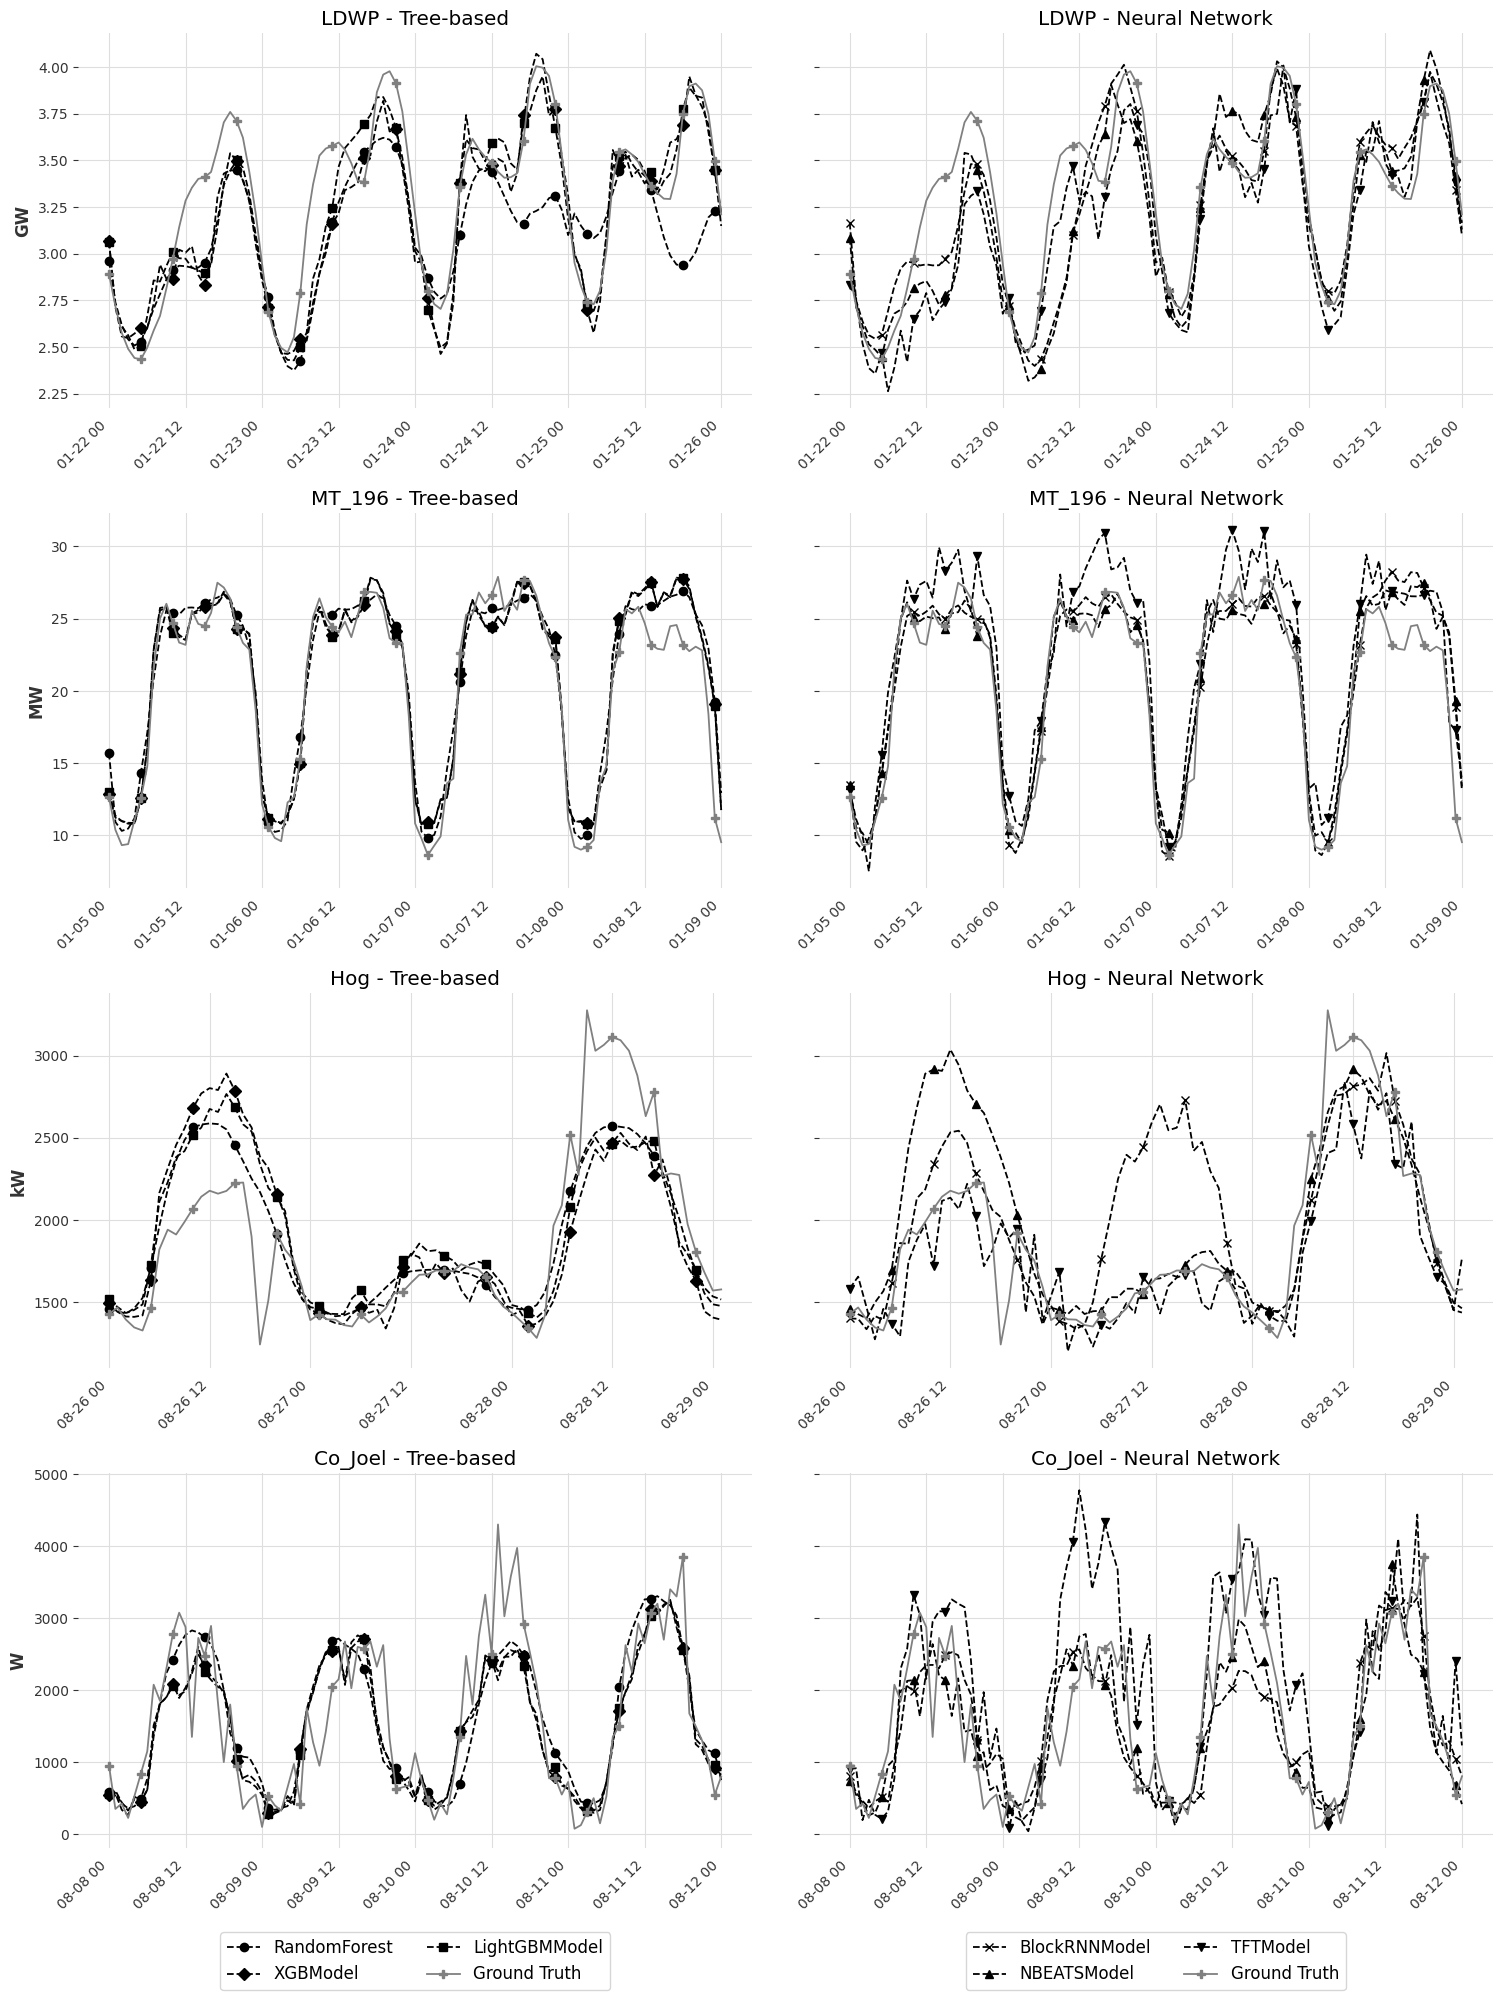

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assuming d_dfs_location, model_groups, horizon, season, model2shape, unit, and dt_highest_peak are defined
model_classes = ["Tree-based", "Neural Network"]

# Create the figure
fig = plt.figure(figsize=(30, 5*len(d_dfs_location)))

# Create a GridSpec for the main rows
outer_grid = gridspec.GridSpec(len(d_dfs_location), 1, figure=fig)

for i, ((scale,location), df_all) in enumerate(d_dfs_location.items()):

    unit = scale2unit[scale]
    # Create a nested GridSpec for each row
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, len(model_classes)*2, subplot_spec=outer_grid[i], wspace=0.1, hspace=0.1)

    first_ax = None  # Initialize the variable to store the first Axes object in each row

    for j, model_type in enumerate(model_classes):
        # If it's the first subplot in the row, create it normally
        if j == 0:
            ax = fig.add_subplot(inner_grid[j])
            first_ax = ax  # Store this Axes object to use as a reference for sharing the y-axis
        else:
            # For subsequent subplots in the row, share the y-axis with the first subplot
            ax = fig.add_subplot(inner_grid[j], sharey=first_ax)

        models_to_plot = model_groups[model_type]
        filtered_cols = [col for col in df_all.columns if str(horizon) + " Hours" in col and season in col or "Ground Truth" in col]
        filtered_cols = [col for col in filtered_cols for model in models_to_plot if model in col] + ['Ground Truth']

        df_plot = df_all[filtered_cols]

        for col in df_plot.columns:
            if col != "Ground Truth":
                model = col.split(" ")[0]
            else:
                model = col

            ax.plot(df_plot[col], label=model, marker=model2shape[model], markevery=5, color="grey" if model == "Ground Truth" else "black", linestyle='solid' if model == 'Ground Truth' else "dashed")

        ax.grid(True, axis='x')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        if i == len(d_dfs_location) - 1:  # Show legend only for the last set of plots
            ax.legend(frameon=True, ncol=2, loc="lower center", bbox_to_anchor=(0.5, -0.4))

        if j == 0:
            ax.set_ylabel(f'{unit}')

        ax.set_title(f'{location2accro[location]} - {model_type}')

        # Hide y-axis labels for subplots that share the y-axis
        if j != 0:
            plt.setp(ax.get_yticklabels(), visible=False)

        

fig.tight_layout()
fig.show()


In [ ]:
for format in ['png', 'pdf']:
    fig.savefig(os.path.join(FIG_DIR,f'plot_1_tree_vs_nn.{format}'), bbox_inches='tight')

#wandb.log({f'plot_3_side-by-side_horizons_heat_wave_{run_to_visualize}_{season}_{algorithm}': wandb.Image(fig)})


## Plot 2: NN. Tree-based, Benchmark

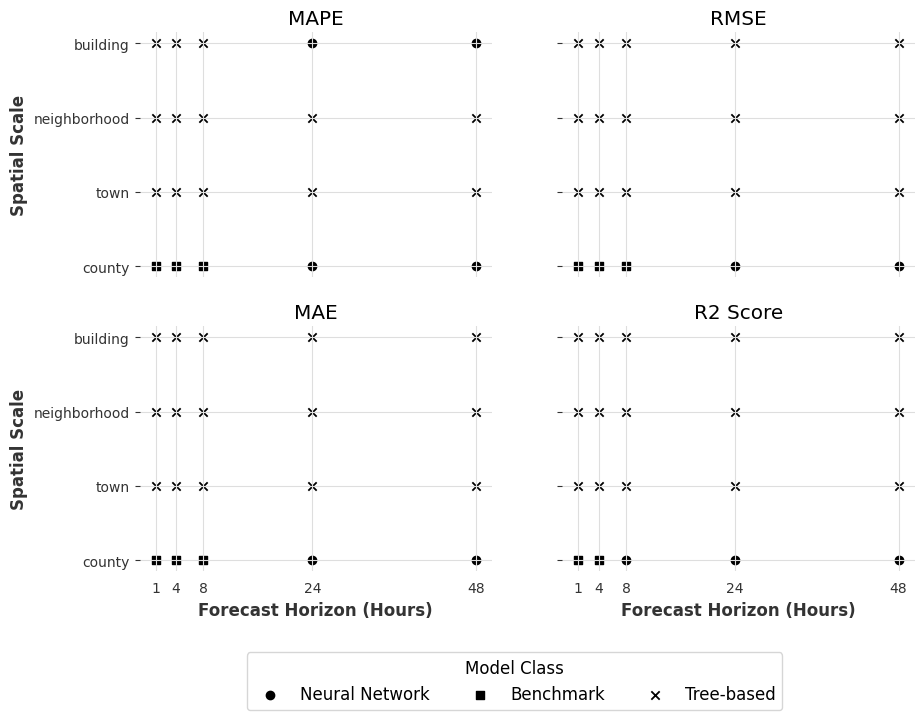

In [9]:
fig, axs = plt.subplots(2,2, figsize=(10,7), sharex=True, sharey=True)

axs = axs.ravel()

for i, (ax, metric_of_interest) in enumerate(zip(axs, ['mape', 'rmse', 'mae', 'r2_score'])):

    df_metrics_all_scales = pd.DataFrame()

    for scale, df in dfs_sorted.items():
        scale = "_".join(scale.split("_")[:2])
        df['scale'] = scale
        df_metrics_all_scales = df_metrics_all_scales.append(df)

    # marginalize over the season
    df_metrics_grouped = df_metrics_all_scales.groupby(['scale', 'model', 'horizon_in_hours']).mean()[[metric_of_interest]].reset_index()

    df = get_best_model_per_scale_and_horizon(df_metrics_grouped, metric_of_interest)


    shape2model = {v: k for k, v in model2shape.items()}


    # Create a list to store the handles and labels for the legend
    legend_handles = []
    legend_labels = []


    # Map the colors and shapes to the DataFrame
    df['group'] = df['model'].map(model2group)
    df = df.groupby(['group', 'horizon_in_hours', 'scale']).mean().reset_index()

    df['shape'] = df['group'].map(group2shape)

    for scale, df_scale in df.groupby('scale'): # this for loop is to make sure the order of scales is from county to neighborhood
        for shape in set(df_scale['shape']):
            x = df_scale.loc[(df_scale['shape'] == shape), 'horizon_in_hours']
            y = df_scale.loc[(df_scale['shape'] == shape), 'scale']
            y = [val.split("_")[1] for val in y.values]
            label = f'{shape2group[shape]}'
            scatter = ax.scatter(x, y, marker=shape, label=label, color="black")
            if label not in legend_labels:
                legend_handles.append(scatter)
                legend_labels.append(label)

    # Set the x ticks and labels
    ax.set_xticks([1, 4, 8, 24, 48])

    if i >= 2 :
        ax.set_xlabel('Forecast Horizon (Hours)')

    if i %2 == 0:
        ax.set_ylabel('Spatial Scale')

    ax.set_title(f'{metric_dict[metric_of_interest]}')

    # Set the title for each subplot


    # Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model Class', loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=True)




In [ ]:
for format in ['png', 'pdf']:
    fig.savefig(os.path.join(FIG_DIR,f'plot_2_best_model_class_all_metrics.{format}'), bbox_inches='tight')

## Plot 3: Skill scores

In [11]:
df

,group,horizon_in_hours,scale,rmse,mae,r2_score,smape,mape,max_peak_error,mean_n_peak_error,rmse_skill,mae_skill,r2_score_skill,smape_skill,mape_skill,max_peak_error_skill,mean_n_peak_error_skill,shape
5,Neural Network,1,1_county,0.115358,0.082839,0.909021,3.284014,0.032561,0.487573,0.435154,-2.240091,-2.226213,0.082967,-2.109108,-2.088001,-2.146407,-2.131625,o
6,Neural Network,4,1_county,0.142569,0.101137,0.877642,4.044294,0.040086,0.877017,0.756154,-0.572339,-0.677232,0.074460,-0.641485,-0.639163,-0.507948,-0.527618,o
7,Neural Network,8,1_county,0.170460,0.120658,0.840018,4.828672,0.047563,1.008890,0.913999,-0.278611,-0.340981,0.062368,-0.322908,-0.321146,-0.566366,-0.484770,o
8,Neural Network,24,1_county,0.189373,0.137457,0.807639,5.548940,0.054305,1.091845,0.989451,-0.065154,-0.084681,0.022308,-0.085615,-0.087100,-0.495304,-0.398751,o
9,Neural Network,48,1_county,0.219882,0.160207,0.752589,6.481100,0.062832,1.217836,1.138789,0.044461,0.039066,-0.035261,0.035403,0.028904,-0.245910,-0.210551,o
10,Tree-based,1,1_county,0.077185,0.056288,0.962431,2.305840,0.022870,0.387838,0.330480,-1.191536,-1.190830,0.028960,-1.174167,-1.161717,-1.525909,-1.403001,x
11,Tree-based,4,1_county,0.121951,0.088793,0.910690,3.641898,0.036126,0.533059,0.501696,-0.360146,-0.465895,0.039241,-0.466797,-0.466862,-0.009617,-0.097983,x
12,Tree-based,8,1_county,0.151249,0.109833,0.868010,4.485092,0.044324,0.744988,0.703546,-0.153191,-0.219486,0.031121,-0.221717,-0.224723,-0.256943,-0.229583,x
13,Tree-based,24,1_county,0.199715,0.146526,0.798820,5.873184,0.057074,0.860080,0.836765,-0.105240,-0.124345,0.031846,-0.124964,-0.121762,-0.264143,-0.241691,x
14,Tree-based,48,1_county,0.253343,0.185325,0.701688,7.425052,0.071046,1.073741,1.050747,-0.068476,-0.067189,0.031880,-0.071038,-0.068685,-0.137474,-0.145673,x


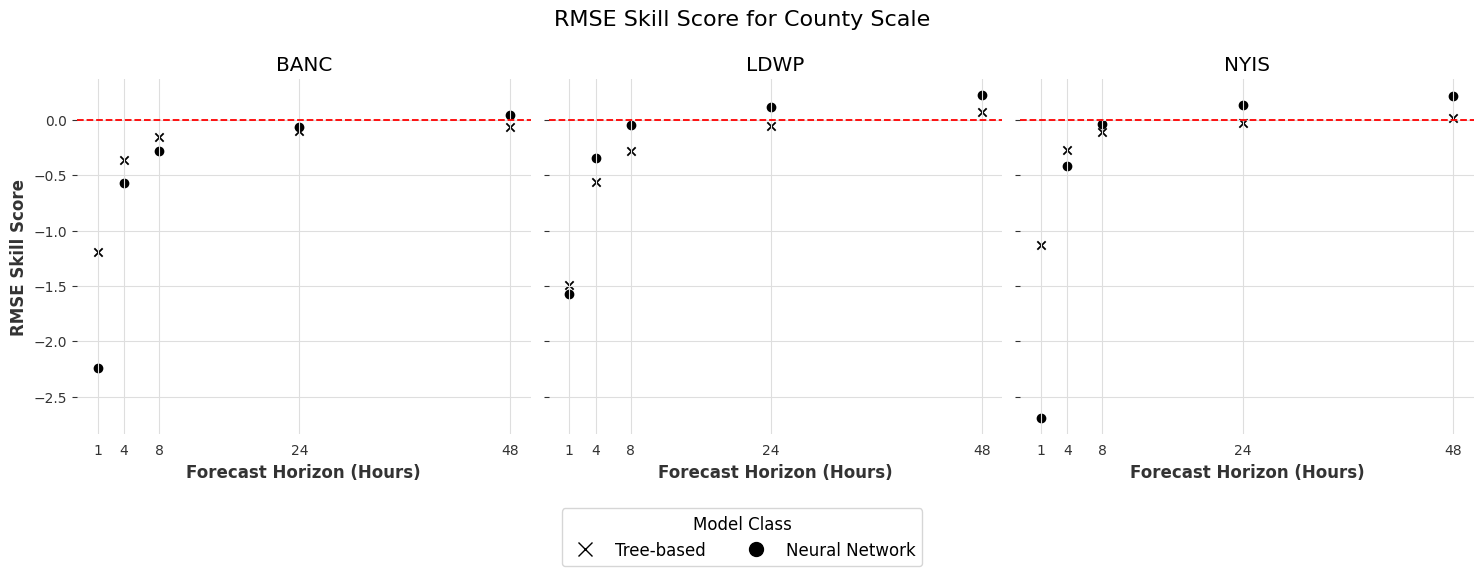

In [15]:
# Set these:

spatial_scale = '1_county' # options are '1_county', '2_town', '3_village', '4_neighborhood', '5_building'
metric_of_interest = 'rmse_skill' # options are 'mape', 'rmse', 'mae', 'smape','r2_score', 'max_peak_error', 'mean_n_peak_error', 'nle', or any of their skill scores



dfs_sorted_plot = dfs_sorted.copy()
keys = list(dfs_sorted_plot.keys())
for key in keys:
    if not spatial_scale in key:
        del dfs_sorted_plot[key]



fig, axs = plt.subplots(1, len(dfs_sorted_plot), figsize=(5*(len(dfs_sorted_plot)),5), sharex=True, sharey=True)

    
axs = axs.ravel()

# Create a list to store the handles and labels for the legend
model_handles = []
season_handles = []
model_labels = []
season_labels = []

grey_color = 'black'
for i, ax in enumerate(axs):

    name, df = list(dfs_sorted_plot.items())[i]

    df.groupby(['scale', 'model', 'horizon_in_hours']).mean()[[metric_of_interest]].reset_index()

    df['group'] = df['model'].map(model2group)

    df = df.groupby(['group', 'horizon_in_hours', 'scale']).mean().reset_index()

    
    #df['color'] = df['season'].map(season2color)
    df['shape'] = df['group'].map(group2shape)

    # exclude 24 hour persistence
    df = df.loc[df['group'] != 'Benchmark']

    for shape in set(df['shape']):
        # Plot x and y data
        x = df.loc[(df['shape'] == shape), 'horizon_in_hours']
        y = df.loc[(df['shape'] == shape), metric_of_interest]
        ax.scatter(x, y, marker=shape, color = "black")

        # Add to model and season legends
        model_label = shape2group[shape]
        if model_label not in model_labels:
            model_handle = mlines.Line2D([], [], color=grey_color, marker=shape, linestyle='None', markersize=10, label=model_label)
            model_handles.append(model_handle)
            model_labels.append(model_label)

    # Set the x ticks and labels
    ax.set_xticks([1, 4, 8, 24, 48])
    ax.set_xlabel('Forecast Horizon (Hours)')

    # Set the y label
    if i == 0:
        ax.set_ylabel(f'{metric_dict[metric_of_interest]}')

    # Set the title for each subplot
    ax.set_title(f'{location2accro["_".join(name.split("_")[2:])]}')

    # Add grid for each subplot
    ax.grid(True)

    # Add a horizontal red dashed line at y = 0
    if "skill" in metric_of_interest:
        ax.axhline(y=0, color='red', linestyle='--')

# Create a single legend for all subplots
fig.legend(handles=model_handles, labels=model_labels, title='Model Class', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)

# Set the title for each subplot
fig.suptitle(f'{metric_dict[metric_of_interest]} for {spatial_scale.split("_")[1].capitalize()} Scale', fontsize=16)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [16]:
for format in ['png', 'pdf']:
    fig.savefig(os.path.join(FIG_DIR,f'plot_3_{spatial_scale}_{metric_of_interest}.{format}'), bbox_inches='tight')

# Detailed Analysis Per Season

## Plot 4: 

## Per Model

### Plot 1: Skill Score vs Horizon for each model and season

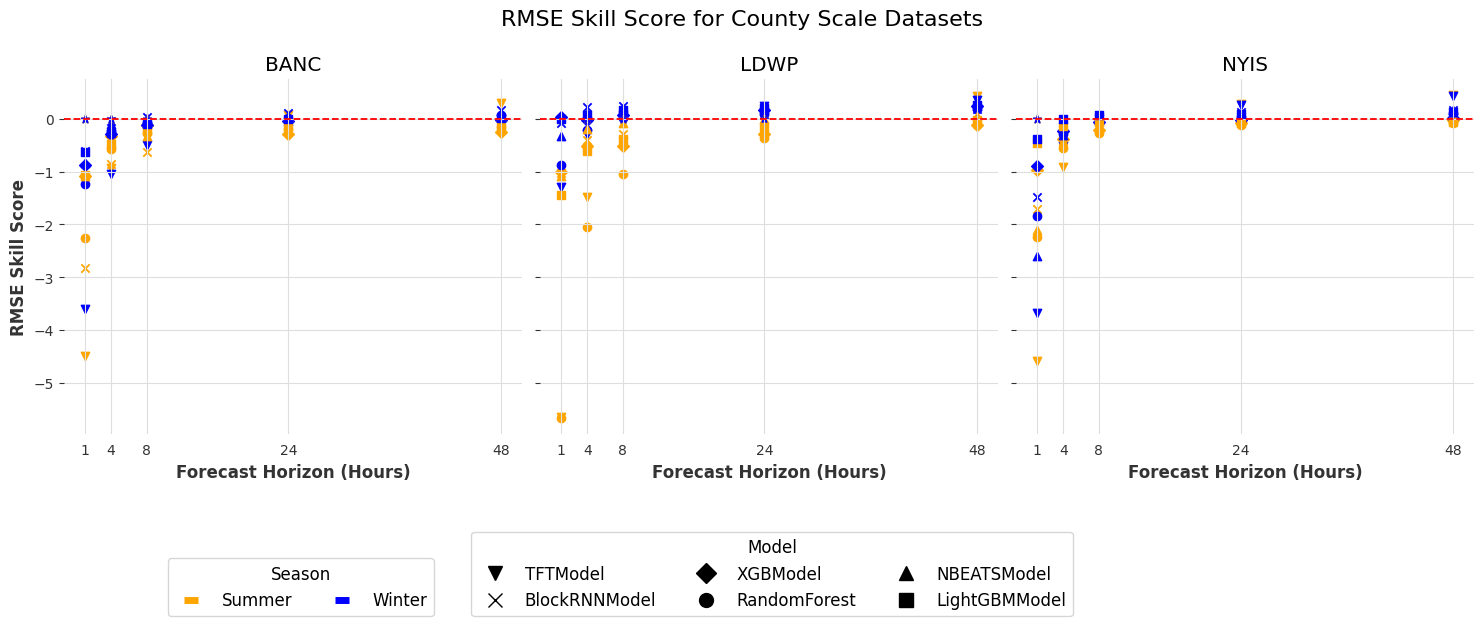

In [19]:
# Set these:

spatial_scale = '1_county' # options are '1_county', '2_town', '3_village', '4_neighborhood', '5_building'
metric_of_interest = 'rmse_skill' # options are 'mape', 'rmse', 'mae', 'smape','r2_score', 'max_peak_error', 'mean_n_peak_error', 'nle', or any of their skill scores

dfs_sorted_plot = dfs_sorted.copy()
keys = list(dfs_sorted_plot.keys())
for key in keys:
    if not spatial_scale in key:
        del dfs_sorted_plot[key]



fig, axs = plt.subplots(1, len(dfs_sorted_plot), figsize=(5*(len(dfs_sorted_plot)),5), sharex=True, sharey=True)

    
axs = axs.ravel()

# Create a list to store the handles and labels for the legend
model_handles = []
season_handles = []
model_labels = []
season_labels = []

grey_color = 'black'
for i, ax in enumerate(axs):

    name, df = list(dfs_sorted_plot.items())[i]
    df['color'] = df['season'].map(season2color)
    df['shape'] = df['model'].map(model2shape)

    # exclude 24 hour persistence
    df = df.loc[df['model'] != '48-Hour Persistence']

    for shape in set(df['shape']):
        for color in set(df.loc[df['shape'] == shape, 'color']):
            # Plot x and y data
            x = df.loc[(df['shape'] == shape) & (df['color'] == color), 'horizon_in_hours']
            y = df.loc[(df['shape'] == shape) & (df['color'] == color), metric_of_interest]
            ax.scatter(x, y, c=color, marker=shape)

            # Add to model and season legends
            model_label = shape2model[shape]
            season_label = color2season[color]
            if model_label not in model_labels:
                if model_label != "LinearRegressionModel":
                    model_handle = mlines.Line2D([], [], color=grey_color, marker=shape, linestyle='None', markersize=10, label=model_label)
                    model_handles.append(model_handle)
                    model_labels.append(model_label)
            if season_label not in season_labels:
                season_handle = mlines.Line2D([], [], color=color, marker='_', linestyle='None', markersize=10,markeredgewidth=5,  label=season_label)
                season_handles.append(season_handle)
                season_labels.append(season_label)

    # Set the x ticks and labels
    ax.set_xticks([1, 4, 8, 24, 48])
    ax.set_xlabel('Forecast Horizon (Hours)')

    # Set the y label
    if i == 0:
        ax.set_ylabel(f'{metric_dict[metric_of_interest]}')

    # Set the title for each subplot
    ax.set_title(f'{location2accro["_".join(name.split("_")[2:])]}')

    # Add grid for each subplot
    ax.grid(True)

    # Add a horizontal red dashed line at y = 0
    if "skill" in metric_of_interest:
        ax.axhline(y=0, color='red', linestyle='--')

# Create a single legend for all subplots
fig.legend(handles=model_handles, labels=model_labels, title='Model', loc='lower center', bbox_to_anchor=(0.52, -0.25), ncol=len(model_handles)//2, frameon=True)
fig.legend(handles=season_handles, labels=season_labels, title='Season', loc='lower right', bbox_to_anchor=(0.3, -0.25), ncol=len(season_handles), frameon=True)

# Set the title for each subplot
fig.suptitle(f'{metric_dict[metric_of_interest]} for {spatial_scale.split("_")[1].capitalize()} Scale Datasets', fontsize=16)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [20]:
for format in ['png', 'pdf']:
    fig.savefig(os.path.join(FIG_DIR,f'plot_4_{spatial_scale}_{metric_of_interest}.{format}'), bbox_inches='tight')

### Plot 4: Comparing Spatial Scales (mean of datasets per season)

In [ ]:
metric_of_interest = "mape"

df_metrics_all_scales = pd.DataFrame()

for scale, df in dfs_sorted.items():
    scale = "_".join(scale.split("_")[:2])
    df['scale'] = scale
    df_metrics_all_scales = df_metrics_all_scales.append(df)

df_metrics_grouped = df_metrics_all_scales.groupby(['season', 'scale', 'model', 'horizon_in_hours']).mean()[[metric_of_interest]].reset_index()

season = 'Winter'

fig, axs = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)

axs = axs.ravel()
# Create a list to store the handles and labels for the legend
legend_handles = []
legend_labels = []

for i, ax in enumerate(axs):

    season = list(season2color.keys())[i]

    df_metrics_grouped_season = df_metrics_grouped.loc[df_metrics_grouped['season'] == season]

    df = get_best_model_per_scale_and_horizon(df_metrics_grouped_season, metric_of_interest)

    shape2model = {v: k for k, v in model2shape.items()}

    # Map the colors and shapes to the DataFrame
    df['shape'] = df['model'].map(model2shape)

    for scale, df_scale in df.groupby('scale'):
        for shape in set(df_scale['shape']):
            x = df_scale.loc[(df_scale['shape'] == shape), 'horizon_in_hours']
            y = df_scale.loc[(df_scale['shape'] == shape), 'scale']
            label = f'{shape2model[shape]}'
            if season == 'Winter':
                ax.scatter(x, y, marker=shape, label=label, color=season2color[season])
            else:
                ax.scatter(x, y, marker=shape, label=label, color=season2color[season])
            if label not in legend_labels:
                model_handle = mlines.Line2D([], [], color="black", marker=shape, linestyle='None', markersize=10, label=model_label)
                legend_labels.append(label)
                legend_handles.append(model_handle)

    # Set the x ticks and labels
    ax.set_xticks([1, 4, 8, 24, 48])
    ax.set_xlabel('Forecast Horizon (Hours)')
    



    # Set the y label
    if i == 0:
        ax.set_ylabel('Spatial Scale')

    # Set the title for each subplot
    ax.set_title(f'{season}')


# Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=True)

fig.suptitle(f'Best Model by {metric_dict[metric_of_interest]}')
# Adjust the spacing between subplots
#fig.tight_layout()

# Show the plot
plt.show()


# Net Load Error Plots

In [ ]:
from utils.paths import RESULTS_DIR

scale = "1_county"
location = "Los_Angeles"

df_opr = pd.read_csv(os.path.join(RESULTS_DIR, 'nle_results', scale, location, "48_Summer_BlockRNNModel_operations.csv"), index_col=0)
df_nle_stats = pd.read_csv(os.path.join(RESULTS_DIR, 'nle_results', scale, location, "48_Summer_BlockRNNModel_stats.csv"), index_col=0)

In [ ]:
df_nle_stats = df_nle_stats.set_index("index")

In [ ]:
df_nle_stats

# Error analysis

In [ ]:
from evaluation import load_eval_dict
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np



### Error & Data distributions 

In [ ]:
from evaluation import load_eval_dict
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np


scale_locs = {
    "5_building": ["building_1", "building_2"],
    "4_neighborhood": ["neighborhood_0", "neighborhood_1", "neighborhood_2"],
    "2_town": ["town_0", "town_1", "town_2"],
    "1_county": ["Los_Angeles", "New_York", "Sacramento"],
}

df_compare_all = pd.DataFrame()

for scale, locations in scale_locs.items():
    for location in locations:

        print(scale, location)

        dict_result_n_ahead = load_eval_dict(scale, location)


        for season in ["Summer", "Winter"]:
            gt = dict_result_n_ahead[48][season][-1].pd_dataframe()
            gt.columns = ["GT"]
            for horizon in [4,8,24,48]:
                ts_list_per_model = dict_result_n_ahead[horizon][season][0]
                for model_name, ts_list in ts_list_per_model.items():
                    list_df_compare = []
                    for ts in ts_list:
                        list_df_compare.append(ts.pd_dataframe().join(gt).reset_index(drop=True))

                    df_compare = pd.concat(list_df_compare, axis=0)
                    df_compare.columns = ["pred", "gt"]
                    df_compare["horizon"] = horizon
                    df_compare["season"] = season
                    df_compare["model"] = model_name
                    df_compare["scale"] = scale
                    df_compare["location"] = location

                    df_compare_all = pd.concat([df_compare_all, df_compare], axis=0)



In [ ]:
df_compare_all.to_parquet("/Users/nikolaushouben/Desktop/WattCast/compare_all.parquet")


In [ ]:

df_compare_all = pd.read_parquet("/Users/nikolaushouben/Desktop/WattCast/compare_all.parquet")

In [ ]:
df_compare_all["type"] = df_compare_all["model"].map(model2group)
df_compare_all["error"] = (df_compare_all["gt"] - df_compare_all["pred"])
df_compare_all = df_compare_all.loc[df_compare_all["type"] != "Benchmark"]
df_compare_all = df_compare_all.dropna(axis = 0)

In [ ]:
df_skew = df_compare_all.groupby(["season", "scale", "type"])["error"].apply(lambda x: skew(x)).to_frame("skew")
df_kurt = df_compare_all.groupby(["season", "scale", "type"])["error"].apply(lambda x: kurtosis(x)).to_frame("kurtosis")

df_stats = pd.merge(df_skew, df_kurt, left_index=True, right_index=True)

In [ ]:
# switch level 0 and 1 of columns to get the right order

df_stats = df_stats.unstack(0)

In [ ]:
df_stats

In [ ]:
df_stats.unstack()

### Histograms

In [ ]:

location = "Los_Angeles"
horizon = 48

df_hist = df_compare_all.loc[(df_compare_all["location"] == location) & (df_compare_all["horizon"] == horizon)].sort_values(by=["season"])


grouped = df_hist.groupby(["season", "model"])["error"]

n_plots = len(grouped)

fig, axs = plt.subplots(2,6, figsize=(20,5), sharex=True, sharey=False)

axs = axs.ravel()

for i, (name, group) in enumerate(grouped):
    ax = axs[i]
    group.hist(ax=ax, bins = 50)
    ax.set_title(name[1], fontsize=12)
    ax.set_xlabel("Error")
    ax.set_ylabel("Count")

fig.subplots_adjust(hspace=0.5)
fig.suptitle("Summer", fontsize=14)
fig.text(0.5, 0.5, 'Winter', ha='center', va='center', fontsize=14, transform=fig.transFigure)


In [ ]:
for format in ['png', 'pdf']:
    fig.savefig(os.path.join(os.getcwd(),'results','figs',f'plot_5_error_dist_{location}_{horizon}.{format}'), bbox_inches='tight')


# Training time, runtime, performance plots

In [ ]:
# data extracted from training machine

training = {"RandomForest":
128.731,
"XGBModel":
64.162,
"BlockRNNModel":
151.438,
"NBEATSModel":
806.806,
"TFTModel": 1400.2,
"LinearRegressionModel":
0.4087}

# for the entire horizon
inference = {"RandomForest":
0.0003,
"XGBModel":
0.0003,
"BlockRNNModel":
0.0003,
"NBEATSModel":
0.0003,
"TFTModel": 0.0003,
"LinearRegressionModel":
0.0003}
